<a href="https://colab.research.google.com/github/samarjahanahmedburney/AccidentSeverityPrediction/blob/main/AccidentSeverityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **💵 Project Title:** Accident Severity Prediction
# **🙋‍♀️ Author:** Samar Jahan Burney
# **📄 Dataset** Description:

Collected from Addis Ababa Sub-city police departments (2017–2020).

Prepared from manual road traffic accident records.

Sensitive information removed; fully encoded for ML.

**Instances:** 12,316 accidents

**Features**: 32

**Target:** Accident_severity (multi-class classification: e.g., Fatal, Serious, Slight)

**🎯 Objective:**
Build a machine learning classification model to predict the severity of an accident based on the features.

**💡 Notes:**

Multi-class classification problem.

Imbalanced target classes (Fatal injuries are rare).

Possible preprocessing steps: missing value handling, encoding categorical variables, feature scaling.

Model choices: Logistic Regression, Random Forest, LightGBM, XGBoost, etc.

Evaluation metrics: Weighted F1-score, Macro F1-score, Precision, Recall.

In [123]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

# Optional boosted libraries
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None

import pickle

In [122]:
# -------------------
# Load data
# --------------------------
df = pd.read_csv("/content/sample_data/RTA Dataset.csv")
df.head()
print('Data shape:', df.shape)

Data shape: (12316, 32)


In [124]:

# --------------------------
# Quick cleaning / feature engineering
# --------------------------
# Convert Time to hour and time of day
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df['Hour'] = df['Time'].dt.hour.fillna(-1).astype(int)
    df['Time_of_day'] = pd.cut(
        df['Hour'], bins=[-2,5,11,16,20,24], labels=['Late Night','Morning','Noon','Evening','Night'])
    df.drop(columns=['Time'], inplace=True)

# Strip strings
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()


# Replace obvious synonyms
if 'Owner_of_vehicle' in df.columns:
    df['Owner_of_vehicle'] = df['Owner_of_vehicle'].replace({'Owner':'Private','Governmental':'Government'})


In [125]:
df.isnull().sum()

,0
Day_of_week,0
Age_band_of_driver,0
Sex_of_driver,0
Educational_level,0
Vehicle_driver_relation,0
Driving_experience,0
Type_of_vehicle,0
Owner_of_vehicle,0
Service_year_of_vehicle,0
Defect_of_vehicle,0


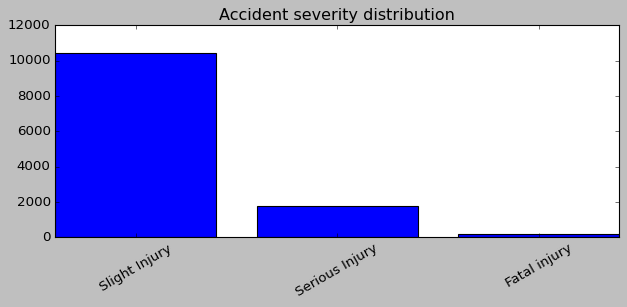

Target counts:
 Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


In [126]:
# --------------------------
# EDA & Graphs
# --------------------------

# Target distribution
plt.figure(figsize=(8,4))
severity_counts = df['Accident_severity'].value_counts()
plt.bar(x=severity_counts.index, height=severity_counts.values)
plt.title('Accident severity distribution')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print('Target counts:\n', df['Accident_severity'].value_counts())


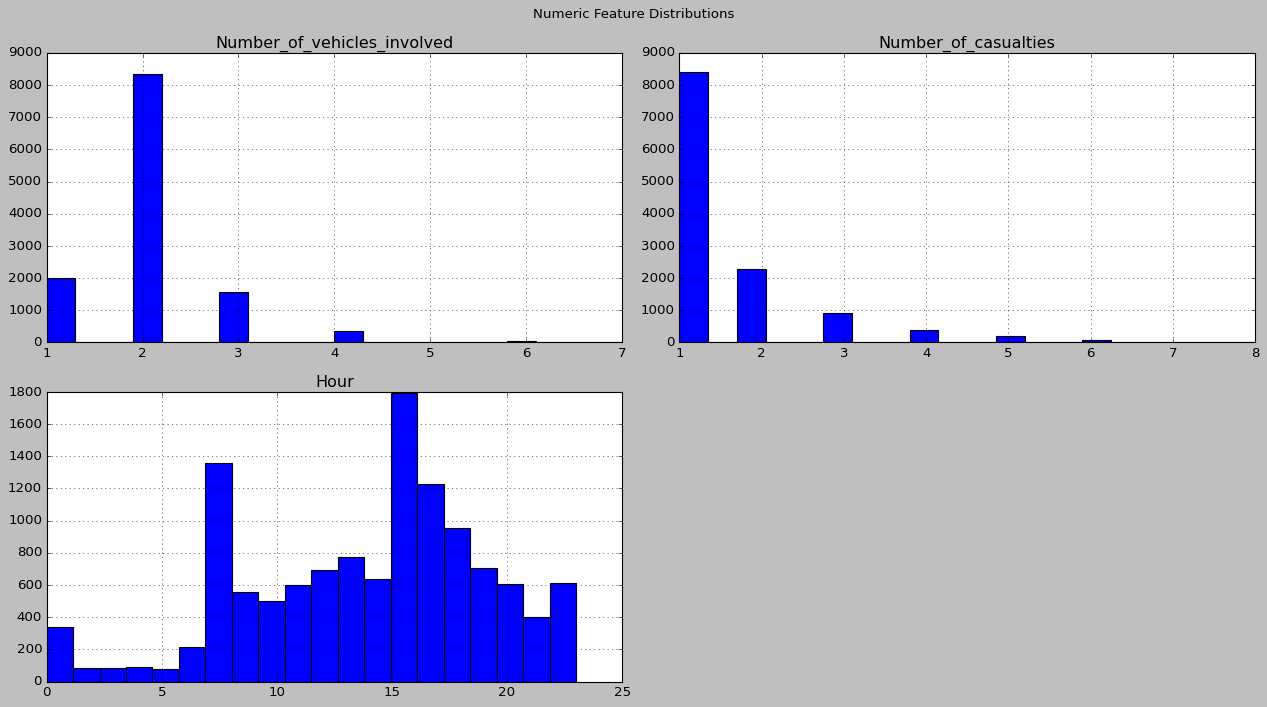

In [127]:
# Numeric histograms
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if num_cols:
    df[num_cols].hist(figsize=(16,9), bins=20)
    plt.suptitle('Numeric Feature Distributions')
    plt.tight_layout()
    plt.show()

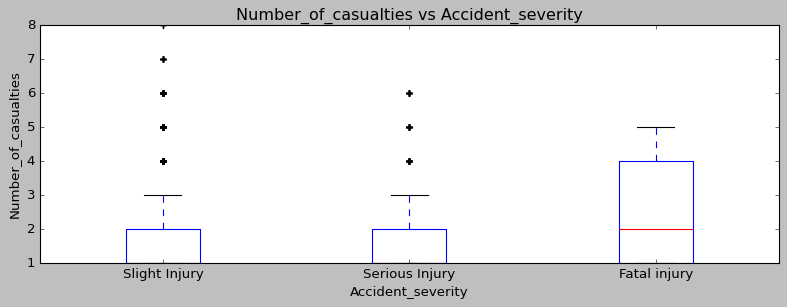

In [128]:
# Boxplots: casualties & vehicles vs severity
unique_severities = df['Accident_severity'].unique()

if 'Number_of_casualties' in df.columns:
    plt.figure(figsize=(10,4))
    # Prepare data for boxplot: list of arrays, one for each severity category
    data_to_plot_casualties = [df[df['Accident_severity'] == s]['Number_of_casualties'].dropna().values for s in unique_severities]
    if data_to_plot_casualties: # Only plot if there's data
        plt.boxplot(data_to_plot_casualties, labels=unique_severities)
    plt.title('Number_of_casualties vs Accident_severity')
    plt.xlabel('Accident_severity')
    plt.ylabel('Number_of_casualties')
    plt.tight_layout(); plt.show()


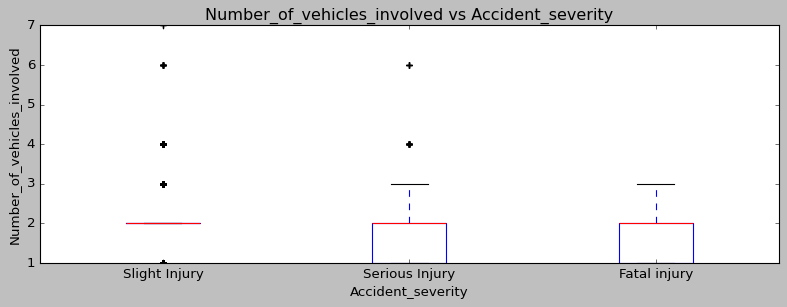

In [129]:
if 'Number_of_vehicles_involved' in df.columns:
    plt.figure(figsize=(10,4))
    # Prepare data for boxplot: list of arrays, one for each severity category
    data_to_plot_vehicles = [df[df['Accident_severity'] == s]['Number_of_vehicles_involved'].dropna().values for s in unique_severities]
    if data_to_plot_vehicles: # Only plot if there's data
        plt.boxplot(data_to_plot_vehicles, labels=unique_severities)
    plt.title('Number_of_vehicles_involved vs Accident_severity')
    plt.xlabel('Accident_severity')
    plt.ylabel('Number_of_vehicles_involved')
    plt.tight_layout(); plt.show()

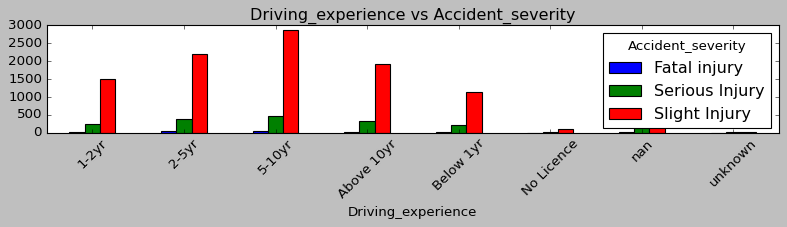

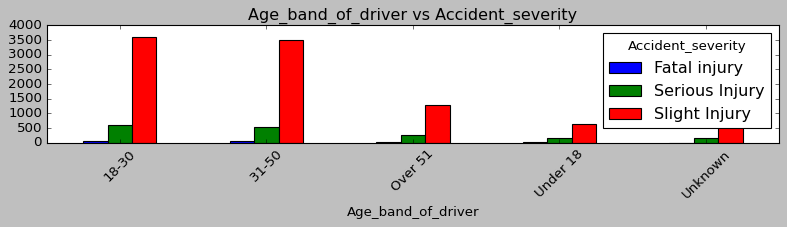

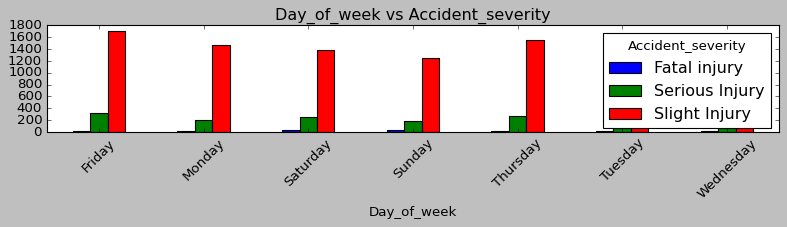

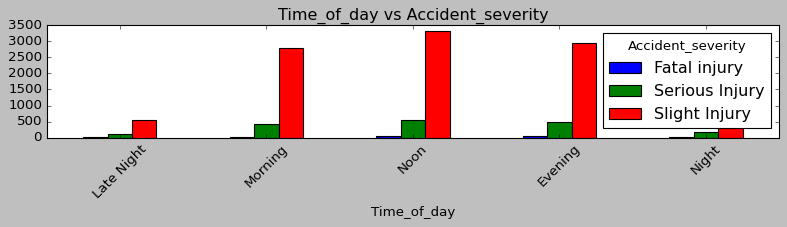

In [130]:
# Example categorical comparisons (top features)
for col in ['Driving_experience','Age_band_of_driver','Day_of_week','Time_of_day']:
    if col in df.columns:
        plt.figure(figsize=(10,3))
        # Replicating sns.countplot(x=col, hue='Accident_severity') with matplotlib
        # Group by the column and Accident_severity, then unstack to get counts for each severity
        plot_data = df.groupby([col, 'Accident_severity']).size().unstack(fill_value=0)
        if not plot_data.empty: # Only plot if there's data
            plot_data.plot(kind='bar', ax=plt.gca(), rot=45) # Use pandas plotting on the current axis
            plt.legend(title='Accident_severity') # Add legend for hue
        plt.title(f'{col} vs Accident_severity')
        plt.xticks(rotation=45)
        plt.tight_layout(); plt.show()

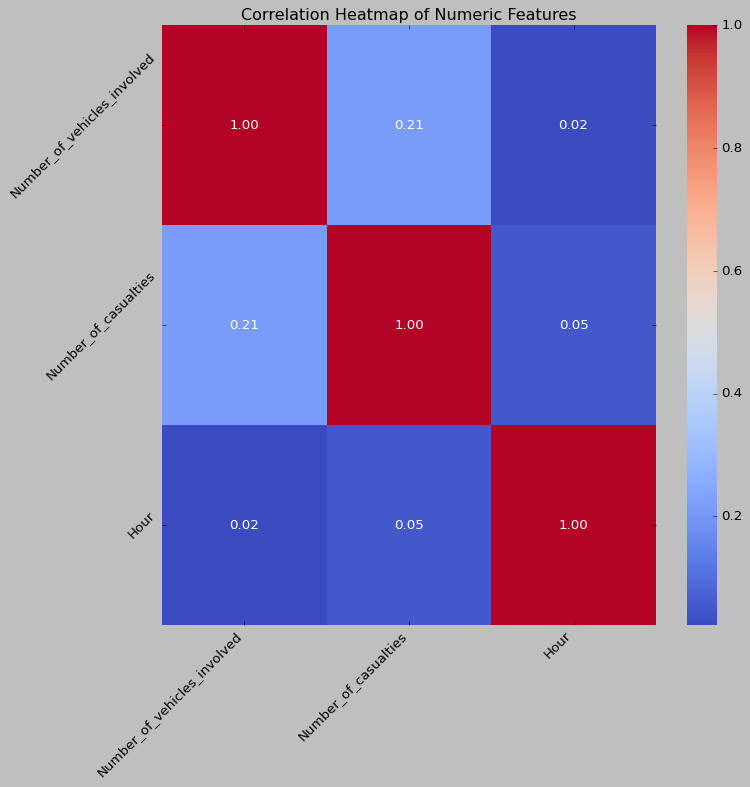

In [131]:
# Correlation heatmap for numeric features
import seaborn as sns

# Ensure num_cols is defined and contains relevant columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

if num_cols:
    plt.figure(figsize=(10,10)) # Adjust figure size dynamically
    corr_matrix = df[num_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found for correlation heatmap.")

In [132]:
# --------------------------
# Prepare data for modeling
# --------------------------
X = df.drop(columns=['Accident_severity'])
y = df['Accident_severity'].astype(str)

# Encode target for models that need numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label mapping:', label_map)

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

Label mapping: {'Fatal injury': np.int64(0), 'Serious Injury': np.int64(1), 'Slight Injury': np.int64(2)}


In [133]:
# Ensure hour is numeric (if exists)
if 'Hour' in X.columns and X['Hour'].dtype == 'object':
    X['Hour'] = pd.to_numeric(X['Hour'], errors='coerce')
    if 'Hour' not in numeric_cols:
        numeric_cols.append('Hour')
        if 'Hour' in categorical_cols:
            categorical_cols.remove('Hour')


In [134]:
# Final train/test split (stratify by encoded target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (9852, 32) Test shape: (2464, 32)


In [135]:
# --------------------------
# Preprocessing pipeline
# --------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')

In [136]:
# --------------------------
# Helper: train & evaluate a pipeline
# --------------------------
from sklearn.base import clone

def train_eval_pipeline(pipeline, X_train, y_train, X_test, y_test, name='model'):
    print('\nTraining', name)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    f1_m = f1_score(y_test, y_pred, average='macro')
    print(f'{name} - weighted F1: {f1_w:.4f} | macro F1: {f1_m:.4f}')
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues', aspect='auto')
    # Add annotations manually as imshow doesn't take 'annot' keyword
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, f'{val}', ha='center', va='center', color='black')
    plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
    plt.yticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
    plt.title(f'Confusion matrix: {name}')
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()
    return pipeline, y_pred

In [137]:
# --------------------------
# Models to compare
# --------------------------
models = {}

# Logistic Regression (baseline)
models['Logistic Regression'] = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# Decision Tree
models['Decision Tree'] = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Random Forest
models['Random Forest'] = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1))
])

# XGBoost (if available)
if XGBClassifier is not None:
    models['XGBoost'] = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
        ('ros', RandomOverSampler(random_state=42)),
        ('clf', XGBClassifier(objective='multi:softprob', num_class=len(le.classes_), use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
    ])

# LightGBM (if available)
if LGBMClassifier is not None:
    models['LightGBM'] = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
        ('ros', RandomOverSampler(random_state=42)),
        ('clf', LGBMClassifier(random_state=RANDOM_STATE)) # Corrected R42 to RANDOM_STATE
    ])



Training Logistic Regression
Logistic Regression - weighted F1: 0.5918 | macro F1: 0.3136
                precision    recall  f1-score   support

  Fatal injury       0.02      0.23      0.04        31
Serious Injury       0.17      0.42      0.25       349
 Slight Injury       0.87      0.53      0.66      2084

      accuracy                           0.51      2464
     macro avg       0.35      0.39      0.31      2464
  weighted avg       0.76      0.51      0.59      2464



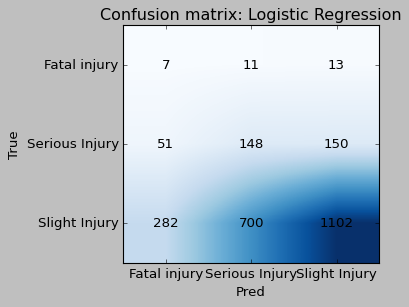


Training Decision Tree
Decision Tree - weighted F1: 0.7483 | macro F1: 0.3981
                precision    recall  f1-score   support

  Fatal injury       0.12      0.16      0.14        31
Serious Injury       0.20      0.21      0.21       349
 Slight Injury       0.86      0.84      0.85      2084

      accuracy                           0.74      2464
     macro avg       0.39      0.41      0.40      2464
  weighted avg       0.75      0.74      0.75      2464



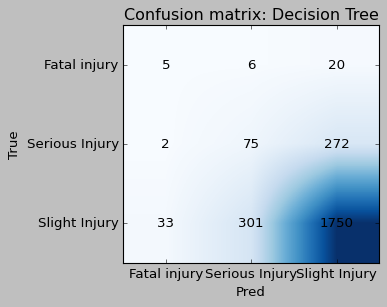


Training Random Forest
Random Forest - weighted F1: 0.7761 | macro F1: 0.3075
                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        31
Serious Injury       1.00      0.00      0.01       349
 Slight Injury       0.85      1.00      0.92      2084

      accuracy                           0.85      2464
     macro avg       0.62      0.33      0.31      2464
  weighted avg       0.86      0.85      0.78      2464



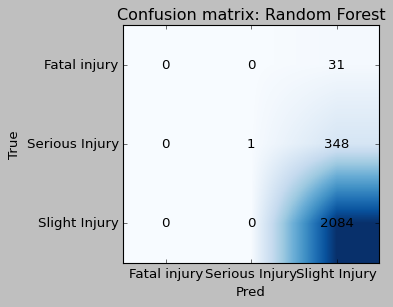


Training XGBoost
XGBoost - weighted F1: 0.7971 | macro F1: 0.3567
                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        31
Serious Injury       0.56      0.09      0.15       349
 Slight Injury       0.86      0.99      0.92      2084

      accuracy                           0.85      2464
     macro avg       0.47      0.36      0.36      2464
  weighted avg       0.80      0.85      0.80      2464



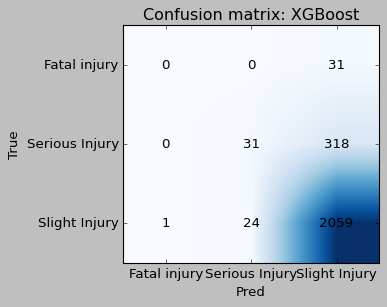


Training LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40798
[LightGBM] [Info] Number of data points in the train set: 24993, number of used features: 218
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM - weighted F1: 0.7845 | macro F1: 0.3284
                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        31
Serious Injury       0.50      0.04      0.07       349
 Slight Injury       0.85      0.99      0.92      2084

      accuracy                           0.85      2464
     macro avg       0.45      0.34      0.33      2464
  weighted avg       0.79      0.85      0.78      2464



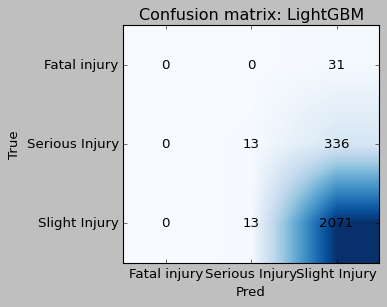

In [115]:
# --------------------------
# Train & evaluate all models
# --------------------------
results = {}
for name, pipe in models.items():
    trained_pipe, y_pred = train_eval_pipeline(pipe, X_train, y_train, X_test, y_test, name=name)
    results[name] = {
        'pipeline': trained_pipe,
        'y_pred': y_pred,
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'f1_macro': f1_score(y_test, y_pred, average='macro')
    }

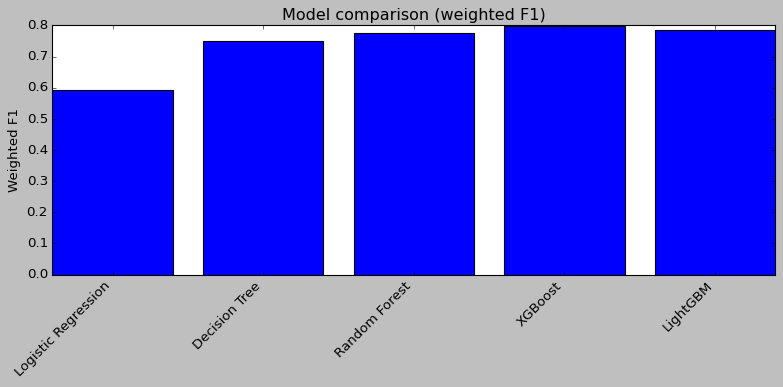

In [116]:
# --------------------------
# Model comparison chart (weighted F1)
# --------------------------
plt.figure(figsize=(10,5))
names = list(results.keys())
scores = [results[n]['f1_weighted'] for n in names]
plt.bar(names, scores)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Weighted F1')
plt.title('Model comparison (weighted F1)')
plt.tight_layout(); plt.show()


In [117]:


# --------------------------
# Feature importance for tree models (best-effort)
# --------------------------
def plot_feature_importance(pipeline, top_n=20, title='Feature importance'):
    try:
        # get preprocessor and model
        pre = pipeline.named_steps['preprocess']
        model = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
        # get feature names from preprocessor
        num_names = []
        cat_names = []
        if hasattr(pre, 'transformers_'):
            for name, trans, cols in pre.transformers_:
                if name == 'num':
                    num_names = cols
                if name == 'cat':
                    # encoder
                    encoder = trans.named_steps['encoder']
                    cat_names = list(encoder.get_feature_names_out(cols))
        feature_names = list(num_names) + cat_names
        importances = model.feature_importances_
        fi = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(top_n)
        plt.figure(figsize=(8,6))
        plt.barh(y=fi['feature'], width=fi['importance']) # Use barh for horizontal bar chart
        plt.title(title); plt.tight_layout(); plt.show()
    except Exception as e:
        print('Could not extract feature importances:', e)


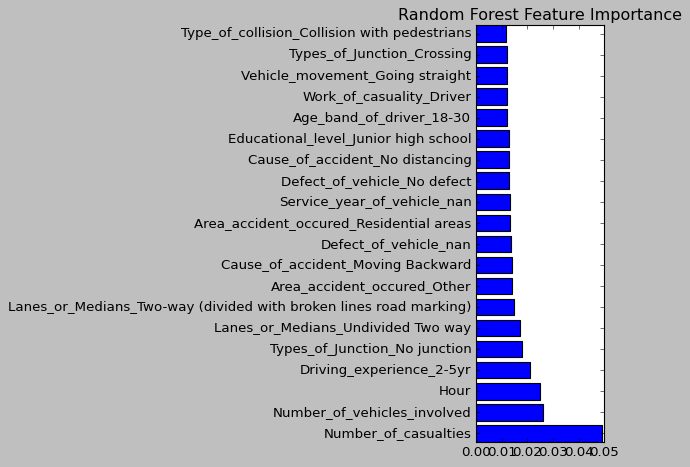

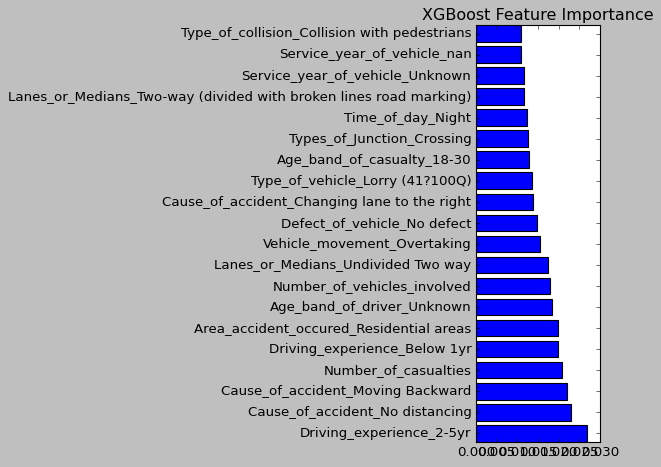

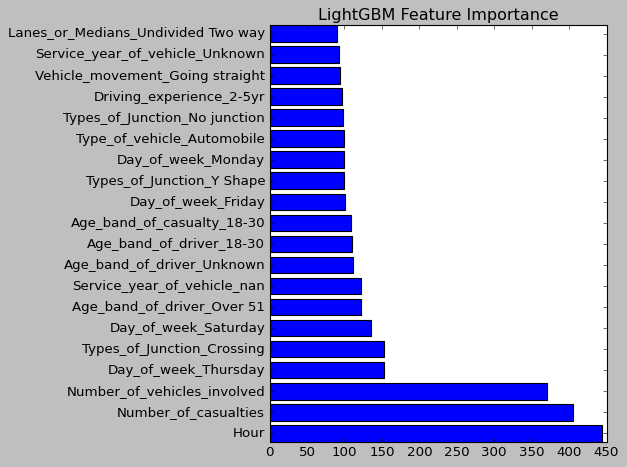

In [118]:
# Plot for Random Forest, XGBoost, LightGBM if present
for candidate in ['Random Forest','XGBoost','LightGBM']:
    if candidate in results:
        plot_feature_importance(results[candidate]['pipeline'], top_n=20, title=f'{candidate} Feature Importance')


In [119]:
# --------------------------
# ROC-AUC multiclass (OVR) for top models
# --------------------------
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

for name in results:
    pipe = results[name]['pipeline']
    if hasattr(pipe, 'predict_proba') or hasattr(pipe.named_steps[list(pipe.named_steps.keys())[-1]], 'predict_proba'):
        try:
            proba = pipe.predict_proba(X_test)
            # Ensure proba has correct dimensions for multiclass OVR
            # If proba is 1D for binary classification, it needs to be reshaped or handled differently
            # Assuming it's already multi-class probability output or a binary case where roc_auc_score handles it
            roc = roc_auc_score(y_test, proba, multi_class='ovr')
            print(f'{name} ROC-AUC (ovr): {roc:.4f}')
        except Exception as ex:
            print(f'Could not compute ROC-AUC for {name}:', ex)

Logistic Regression ROC-AUC (ovr): 0.5845
Decision Tree ROC-AUC (ovr): 0.5480
Random Forest ROC-AUC (ovr): 0.6510
XGBoost ROC-AUC (ovr): 0.6974
LightGBM ROC-AUC (ovr): 0.7128


In [120]:
# --------------------------
# Save best model (by weighted F1)
# --------------------------
best_name = max(results.keys(), key=lambda k: results[k]['f1_weighted'])
print('Best model by weighted F1:', best_name, results[best_name]['f1_weighted'])

best_pipeline = results[best_name]['pipeline']
with open('accident_severity_pipeline.pkl', 'wb') as f:
    pickle.dump({'pipeline': best_pipeline, 'label_encoder': le, 'label_map': label_map}, f)
    print('✅ Saved best model saved successfully!')

Best model by weighted F1: XGBoost 0.7970971528284365
✅ Saved best model saved successfully!


In [121]:
with open('accident_severity_pipeline.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# ***DATA STORY:***
The accident dataset showed a strong imbalance, with most crashes resulting in slight injuries and only a few being serious or fatal. Exploratory analysis revealed that young and inexperienced drivers, along with late-night driving conditions, were more commonly linked with severe accidents. Road and environmental factors such as poor lighting and complex junctions also contributed to higher severity levels. Because fatal cases were very rare, machine-learning models struggled to classify them accurately, even after applying SMOTE and oversampling. Among all models, XGBoost achieved the best overall performance, while Decision Tree handled minority classes slightly better. However, ensemble models tended to predict slight injuries more frequently due to class imbalance. Overall, the project highlights the need for more balanced data to improve prediction of serious and fatal accidents and enhance road-safety interventions.